1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


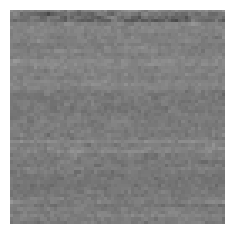

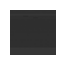

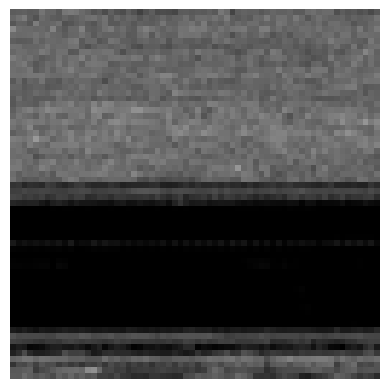

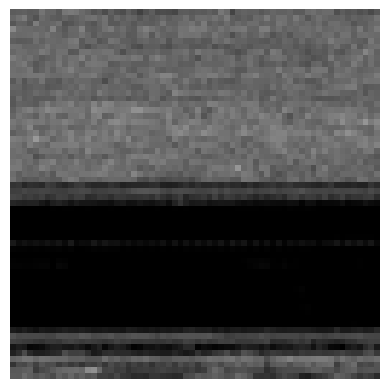

In [ ]:
import os #pentru operații cu sistemul de fișiere
import numpy as np
from math import log #pentru operații numerice și matematice
from PIL import Image #pentru manipularea imaginilor
import tkinter as tk #pentru construirea interfeței grafice
from tkinter import filedialog, Label, Button, Text, Scrollbar, Frame
import matplotlib.pyplot as plt #pentru afișarea grafică a imaginilor în interfața Tkinter
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tensorflow.keras.models import load_model #pentru încarcarea unui model de rețea neuronală și preprocesarea imaginilor
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow.keras.backend as K
from datetime import datetime
import re #pentru operații de timp și procesare cu expresii regulate.

# Director temporar pentru fișierele convertite
temp_dir = './temp/'
os.makedirs(temp_dir, exist_ok=True)

# Metrici personalizate pentru model  - le calculez la antrenare
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Încarcă modelul (modifică calea dacă e necesar)
model_path = 'my_model_64x64.h5'
model = load_model(model_path, custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})

# Lista claselor de malware
malware_classes = [
    "Adialer.C", "Agent.FYI", "Allaple.A", "Allaple.L", "Alueron.gen!J",
    "Autorun.K", "C2LOP.P", "C2LOP.gen!g", "Dialplatform.B", "Dontovo.A",
    "Fakerean", "Instantaccess", "Lolyda.AA1", "Lolyda.AA2", "Lolyda.AA3",
    "Lolyda.AT", "Malex.gen!J", "Obfuscator.AD", "Rbot!gen", "Skintrim.N",
    "Swizzor.gen!E", "Swizzor.gen!I", "VB.AT", "Wintrim.BX", "Yuner.A"
]

# Funcție pentru conversia fișierelor binare la format `.bytes`
def convert_to_bytes(filepath):
    with open(filepath, 'rb') as f:
        binary_content = f.read()

    hex_lines = []
    for i in range(0, len(binary_content), 16):
        line = ' '.join(f'{b:02x}' for b in binary_content[i:i+16])
        hex_lines.append(f"{i:08x} {line}")

    bytes_filepath = os.path.join(temp_dir, 'temp.bytes')
    with open(bytes_filepath, 'w') as f:
        f.write('\n'.join(hex_lines))

    return bytes_filepath


def convert_and_save(array, name):        # Funcție pentru conversia unui fișier .bytes într-o imagine PNG
   
    if array.shape[1] != 16:              # Verific dacă fiecare linie a array-ului are 16 valori.
        raise ValueError("Format incorect. Fișierul trebuie să aibă 16 valori pe linie.")

    
    b = int((array.shape[0] * 16) ** 0.5) # Calculez numărul total de valori și estimează lățimea imaginii ca rădăcina pătrată a acestui număr.
    b = 2 ** (int(log(b) / log(2)) + 1)   # Rotunjesc la cel mai apropiat 2^n.
    a = int(array.shape[0] * 16 / b)      # Calculez înălțimea (a) ca fiind numărul total de valori împărțit la lățimea (b).

    array = array[:a * b // 16, :]        # Trunchiez array-ul pentru a folosi doar liniile complete care pot forma o imagine cu a * b valori.

    array = np.reshape(array, (a, b, 1))  # Remodelez array-ul pentru a obține o imagine cu un canal.
    array = np.repeat(array, 3, axis=2)   # Convertesc la RGB prin repetarea canalului.

    im = Image.fromarray(np.uint8(array)) # Creez imaginea folosind Pillow din array-ul numeric convertit la uint8.
    im = im.resize((64, 64))              # Redimensionez imaginea la 64x64 pixeli.
    
    png_filepath = os.path.join(temp_dir, name + '.png')  # Construiesc calea completă pentru salvarea imaginii PNG în directorul temporar.
    im.save(png_filepath, "PNG")
    
    return png_filepath


# Funcția principală pentru conversia și prelucrarea fișierului
def process_file(filepath):
    #if filepath.endswith('.png') and len(os.path.basename(filepath).split('.')[0]) == 32: #dacă încarc o imagine din setul de test (MALIMG) nu mai fac nimic
        #return filepath
    bytes_filepath = convert_to_bytes(filepath)

    array = []
    with open(bytes_filepath, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) != 17: # Se ignoră liniile care nu au exact 17 componente (1 offset + 16 bytes).
                continue
            array.append([int(value, 16) if value != '??' else 0 for value in parts[1:]])

            #Se extrag cei 16 bytes și:
            #dacă valoarea este în hex (ex: 4d, 5a) → se convertesc la zecimal (int(value, 16)).
            #dacă este necunoscut (??) → se pune 0.
            # Rezultatul: o matrice de numere între 0–255, reprezentând intensități ale pixelilor.

    image_path = convert_and_save(np.array(array), 'temp_image')
    return image_path, bytes_filepath

# Funcția pentru a încărca fișierul și a face predicția
def load_and_predict():
    filepath = filedialog.askopenfilename()
    try:
        image_path, bytes_filepath = process_file(filepath)

        # Afișăm calea și numele fișierului încărcat
        file_info_label.config(text=f"Fișier încărcat: {os.path.abspath(filepath)}")

        # Preprocesăm imaginea manual
        img = load_img(image_path, target_size=(64, 64))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Adaugă dimensiunea lotului
        img_array /= 255.0  # Rescalăm valorile între 0 și 1

        # Facem predicția
        predictions = model.predict(img_array)
        result_text = "\n".join([f"{malware_classes[i]}: {round(p * 100, 2)}%" for i, p in enumerate(predictions[0])])
        result_label.config(text=result_text)

        # Afișăm imaginea byte stream
        display_image(image_path)

        # Afișăm conținutul fișierului .bytes
        display_bytes_content(bytes_filepath)

        # Salvăm rezultatul în fișier
        save_result(filepath, predictions[0])

    except Exception as e:
        result_label.config(text=f"Eroare: {e}")

# Funcție pentru a afișa imaginea în interfață
def display_image(image_path):
    img = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    canvas = FigureCanvasTkAgg(fig, master=image_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(pady=10)

# Funcție pentru a afișa conținutul fișierului .bytes
def display_bytes_content(bytes_filepath):
    with open(bytes_filepath, 'r') as f:
        content = f.read()

    bytes_text.delete(1.0, tk.END)
    bytes_text.insert(tk.END, content)

    # Convertim conținutul hex în bytes și extragem stringuri
    hex_content = content.replace("\n", "").replace(" ", "")
    byte_content = bytes.fromhex(hex_content)
    string_content = extract_strings(byte_content)
    converted_text.delete(1.0, tk.END)
    converted_text.insert(tk.END, string_content)

# Funcție pentru a extrage stringuri din conținutul binar
def extract_strings(byte_content, min_length=4):
    # Expresie regulată pentru a găsi șiruri de caractere alfanumerice și punctuație
    pattern = re.compile(b'[A-Za-z0-9\s\.,;:!?\"\'\-\(\)]{' + str(min_length).encode() + b',}')
    matches = pattern.findall(byte_content)

    # Decodăm și concatenăm caracterele găsite în șiruri continue
    extracted_strings = []
    for match in matches:
        try:
            decoded_string = match.decode('utf-8')
            extracted_strings.append(decoded_string)
        except UnicodeDecodeError:
            continue

    return "\n".join(extracted_strings)

# Funcție pentru a salva rezultatul în fișier
def save_result(filepath, predictions):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    max_class_index = np.argmax(predictions)
    max_class_name = malware_classes[max_class_index]
    max_class_percentage = round(predictions[max_class_index] * 100, 2)

    result_line = f"{timestamp} - {os.path.abspath(filepath)} - {os.path.basename(filepath)} - {max_class_name}: {max_class_percentage}%\n"

    with open("clasificari.txt", "a") as f:
        f.write(result_line)

# Configurare interfață
root = tk.Tk()
root.title("Predictie pe baza fișierului încărcat")
root.geometry("1200x900")  # Dimensiunea ferestrei

load_button = Button(root, text="Încarcă fișier", command=load_and_predict)
load_button.pack(pady=10)

file_info_label = Label(root, text="Fișier încărcat: Niciun fișier încărcat")
file_info_label.pack(pady=5)

result_frame = Frame(root, borderwidth=2, relief="solid")
result_frame.pack(pady=10, fill=tk.BOTH, expand=True)
result_label = Label(result_frame, text="Predicție")
result_label.pack()

# Frame principal pentru imagine și conținutul fișierului .bytes
main_frame = Frame(root)
main_frame.pack(pady=10, fill=tk.BOTH, expand=True)

# Frame pentru imagine
image_frame = Frame(main_frame, borderwidth=2, relief="solid")
image_frame.pack(side=tk.LEFT, padx=10, pady=10, fill=tk.BOTH, expand=True)
image_label = Label(image_frame, text="Imagine generată")
image_label.pack()

# Frame pentru conținutul fișierului .bytes și conversii
bytes_frame = Frame(main_frame, borderwidth=2, relief="solid")
bytes_frame.pack(side=tk.LEFT, padx=5, pady=5, fill=tk.BOTH, expand=True)
bytes_label = Label(bytes_frame, text="Byte Stream")
bytes_label.pack()

bytes_scrollbar = Scrollbar(bytes_frame)
bytes_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

bytes_text = Text(bytes_frame, wrap=tk.NONE, yscrollcommand=bytes_scrollbar.set, height=15, width=50)
bytes_text.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

bytes_scrollbar.config(command=bytes_text.yview)

# Frame pentru conținutul convertit
converted_frame = Frame(main_frame, borderwidth=2, relief="solid")
converted_frame.pack(side=tk.LEFT, padx=5, pady=5, fill=tk.BOTH, expand=True)
converted_label = Label(converted_frame, text="Stringuri extrase")
converted_label.pack()

converted_scrollbar = Scrollbar(converted_frame)
converted_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

converted_text = Text(converted_frame, wrap=tk.NONE, yscrollcommand=converted_scrollbar.set, height=20, width=50)
converted_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

converted_scrollbar.config(command=converted_text.yview)

root.mainloop()
